In [2]:
import iris
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import matplotlib as mpl
import itertools
import pandas as pd

In [3]:
dir_vol = '/data/NAS-ph290/ph290/cmip5/volcello/'
#volcello_fx_ACCESS1-0_historical_r0i0p0.nc
dir_alk = '/data/BatCaveNAS/ph290/noc_talk/'
#talk_Oyr_HadGEM2-ES_rcp85_r1i1p1_2006-2099.nc

In [4]:

def model_names(directory,file_name_format,name_possition):
        files = glob.glob(directory+file_name_format)
        models_tmp = []
        for file in files:
                statinfo = os.stat(file)
                if statinfo.st_size >= 1:
                        models_tmp.append(file.split('/')[-1].split('_')[name_possition])
                        models = np.unique(models_tmp)
        return models



due to a issue with how I've compiled stuff (hdf libraries), I had to do GLODAP on JASMIN like:
cdo vertmean -fldmean -timmean -selvar,TAlk GLODAPv2.2016b.TAlk.nc GLODAPv2.2016b.TAlk_glob_mean.nc
result in:
/data/NAS-ph290/ph290/misc_data/GLODAPv2.2016b.TAlk_glob_mean.nc
mean is (2332.27280205/1.0e3)*1.026
GLODAP = mole equivalent per unit mass
CMIP5 = mole_equivalent / (mol m-3))*1.026
so glodap mean is 2.3929118949033


In [5]:
m1 = model_names(dir_vol,'volcello_fx_*_historical_r0i0p0.nc',2)
m2 = model_names(dir_alk,'talk_Oyr_*_rcp85_r1i1p1_*.nc',2)
models = list(set(m1).intersection(m2))

In [6]:
my_dict = {}

for model in models:
    vol_cube = iris.load_cube(dir_vol+'volcello_fx_'+model+'_historical_r0i0p0.nc','ocean_volume')
    alk_files = glob.glob(dir_alk+'talk_Oyr_'+model+'_rcp85_r1i1p1_*.nc')
    alk_cube = iris.load_cube(alk_files[0],'sea_water_alkalinity_expressed_as_mole_equivalent')[0] # m-3
    vol_cube.data.mask = alk_cube.data.mask
    total_volume = np.ma.sum(vol_cube.data)
#     if 1.2e+18 < total_volume < 1.4e+18: #i.e. only look at the models where I know I am correctly calculating the volume
    my_dict[model] = {}
    total_alk = np.ma.sum(vol_cube.data * alk_cube.data)
    my_dict[model]['total_alk'] = total_alk
    my_dict[model]['mean_alk'] = total_alk/total_volume
    my_dict[model]['total_volume'] = total_volume

df = pd.DataFrame.from_dict(my_dict)


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2030: UserWarning: Gracefully filling 'i' dimension coordinate masked points
  warnings.warn(msg.format(str(cf_coord_var.cf_name)))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2030: UserWarning: Gracefully filling 'j' dimension coordinate masked points
  warnings.warn(msg.format(str(cf_coord_var.cf_name)))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2030: UserWarning: Gracefully filling 'lev' dimension coordinate masked points
  warnings.warn(msg.format(str(cf_coord_var.cf_name)))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2037: UserWarning: Gracefully filling 'lev' dimension coordinate masked bounds
  warnings.warn(msg.format(str(cf_coord_var.cf_name)))
/home/ph290/anaconda2/lib/py

In [7]:
t_alk_file = '/data/NAS-geo01/ph290/observations/glodap_v1/Alkalinity_glob_tot.nc'
glodap_v1_t_alk_cube = (iris.load_cube(t_alk_file)[0,0]/1.0e3)*1.026
p_alk_file = '/data/NAS-geo01/ph290/observations/glodap_v1/PAlk_glob_tot.nc'
glodap_v1_p_alk_cube = (iris.load_cube(p_alk_file)[0,0]/1.0e3)*1.026



/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1935: UserWarning: Ignoring netCDF variable u'Alk' invalid units u'UMOL/KG'
  warnings.warn(msg.encode('ascii', errors='backslashreplace'))


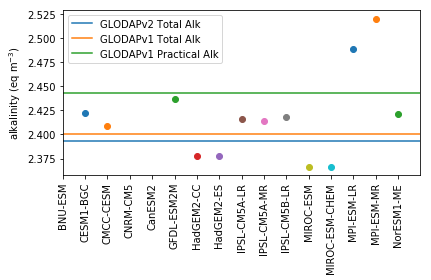

In [13]:
for i,item in enumerate(list(df)):
    if df[item].total_volume < 1.0e20:
        plt.scatter(i,df[item].mean_alk)

plt.plot([0,100],[2.3929118949033,2.3929118949033],label='GLODAPv2 Total Alk')
plt.plot([0,100],[glodap_v1_t_alk_cube.data,glodap_v1_t_alk_cube.data],label='GLODAPv1 Total Alk')
plt.plot([0,100],[glodap_v1_p_alk_cube.data,glodap_v1_p_alk_cube.data],label='GLODAPv1 Practical Alk')
plt.xticks(range(len(list(df))), list(df), rotation='vertical')
plt.xlim([0,len(list(df))])
plt.legend()
plt.ylabel('alkalinity (eq m$^{-3}$)')
plt.tight_layout()
plt.savefig('./figures/global_alkalinity.png')

The total alkalinity (TA) of seawater may be defined as the charge difference between the major conservative (concentration unaffected by changes in pH, pressure, or temperature) cations and anions:
(14)
The small excess positive charge (~ 2 as compared with ~ 600 mmol kg− 1 total positive charge concentration) is balanced by contributions from carbonate, borate, and water alkalinities (Fig. 4):

where PA is the practical alkalinity (alkalinity for most practical purposes). In fact, carbonate alkalinity (CA) is by far the most important contributor to TA, which leads to a useful approximation:

<img src="https://ars.els-cdn.com/content/image/3-s2.0-B9780124095489097177-eq09717-14-9780124095489.gif">

The small excess positive charge (~ 2 as compared with ~ 600 mmol kg− 1 total positive charge concentration) is balanced by contributions from carbonate, borate, and water alkalinities (Fig. 4)

<img src="https://ars.els-cdn.com/content/image/3-s2.0-B9780124095489097177-f09717-04-9780124095489.jpg">

<img src="https://ars.els-cdn.com/content/image/3-s2.0-B9780124095489097177-eq09717-15-9780124095489.gif">


<img src="https://ars.els-cdn.com/content/image/3-s2.0-B9780124095489097177-eq09717-16-9780124095489.gif">